In [69]:
from sklearn.cluster import Birch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, calinski_harabasz_score
import warnings


In [111]:
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['Times new Roman']
plt.rcParams['axes.unicode_minus'] = False

smoothing_window = 12

In [3]:
def birch_ad_with_smoothing(latency_df, threshold):
    """
    birch方法，用于后续根因定位
    """
    anomalies = []
    for svc, latency in latency_df.iteritems():
        if svc != 'timestamp' and 'Unnamed' not in svc and 'rabbitmq' not in svc and 'db' not in svc:
            latency = latency.rolling(window=smoothing_window, min_periods=1).mean()
            x = np.array(latency)
            x = np.where(np.isnan(x), 0, x)
            normalized_x = normalize([x])
            X = normalized_x.reshape(-1, 1)
            brc = Birch(branching_factor=50, n_clusters=None, threshold=threshold, compute_labels=True)
            brc.fit(X)
            brc.predict(X)
            labels = brc.labels_
            n_clusters = np.unique(labels).size
            if n_clusters > 1:
                anomalies.append(svc)
    print("经算法检测，异常的指标为----------------------------------------：", "\n", anomalies)
    return anomalies


In [4]:


def birch(x, branching_factor, threshold):
    """
    birch方法，用于异常检测
    """
    brc = Birch(branching_factor=branching_factor,
                n_clusters=2,
                threshold=threshold,
                compute_labels=True)
    brc.fit(x)
    pred = brc.predict(x)
    return pred



In [64]:

def machine_learning(data, label):
    smoothing_window = 6
    val = data['@value']
    val = val.rolling(window=smoothing_window, min_periods=1).mean()
    x = np.array(val)
    normal_x = normalize([x])
    norm_x = normal_x.reshape(-1, 1)
    threshold = 0.00000001
    branching_factor = 50
    y_pred = birch(norm_x, branching_factor=branching_factor, threshold=threshold)
    F1_score = f1_score(label['target'].values, y_pred)
    Precision = precision_score(label['target'].values, y_pred)
    CH = calinski_harabasz_score(label['target'].values, y_pred)
    print("准确率为--------------------------{}".format(Precision))
    print("f1_score为-----------------------{}".format(F1_score))
    print("CH为-----------------------{}".format(CH))

In [136]:
# 加载数据
normal = pd.read_csv('anomaly_data/1_normaly.csv', index_col='timestamp')
anomaly = pd.read_csv('anomaly_data/1_anomaly.csv', index_col='timestamp')


## Birch参数
threshold：CF-tree中的参数T，叶子结点中每个CF的最大半径，每个聚类特征所有样本形成的超球体的半径值域   
branching_factor: 参数B=L，允许最大叶子聚类特征CF数量，默认50，若样本量比较大的时候，可增大该参数   

In [222]:
norm_X = MinMaxScaler()
norm_X = norm_X.fit_transform(anomaly)
df = pd.DataFrame(norm_X, columns=anomaly.columns)

In [241]:
N = 1

metric = df.iloc[:, N]
normalized_x = normalize([metric])
X = normalized_x.reshape(-1, 1)
brc = Birch(branching_factor=50, 
            threshold=0.005, 
            n_clusters=2, 
            compute_labels=True)
brc.fit(X)
ypred = brc.predict(X)
print(np.sum(ypred))

37


In [243]:
# 绘制散点图
def plot_scatter(D, col_num1, col_num2):
    plt.figure(figsize=(8, 2), dpi=150)
    x = D.iloc[:, col_num1].values
    plt.scatter(x, D.iloc[:, col_num2].values)
    plt.title("scatter")
    plt.axis('off')
    plt.show()

# 绘制全指标折线图
colors = ['blue', 'red', 'yellow', 'pink', 'green', 'orange']
axs = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6']
def plot_plot(D):
    norm_X = MinMaxScaler()
    norm_X = norm_X.fit_transform(D)
    D_ = pd.DataFrame(norm_X, columns=D.columns)
    plt.figure(figsize=(8, 8), dpi=150)
    X = [c for c in range(D_.shape[0])]
    for i in range(D.shape[1]):
        axs[i+1] = plt.subplot(5, 1, i+1)
        plt.plot(X, D_.iloc[:, i], c=colors[i], label=D.columns[i])
        plt.legend()
    plt.show()

# 绘制单指标异常检测结果图
def plot_metric(metric, ypred):
    plt.figure(figsize=(8, 3), dpi=150)
    X = [c for c in range(len(metric))]
    plt.plot(X, metric, color='blue')
    Ypred = [[i, value] for i, value in enumerate(ypred) if value == 1]
    pred_x = [x[0] for x in Ypred]
    pred_y = [metric[j] for j in pred_x]
    plt.scatter(pred_x, pred_y, color='red', marker='o', s=14)
    plt.axis('off')
    plt.show()

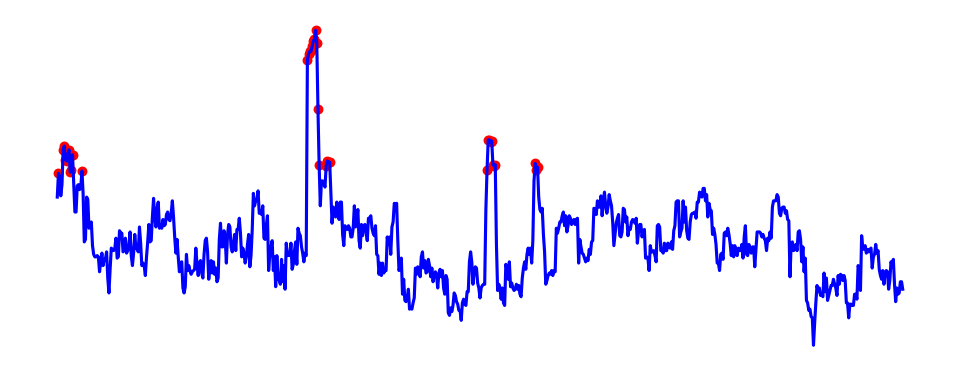

In [244]:
plot_metric(X, ypred)

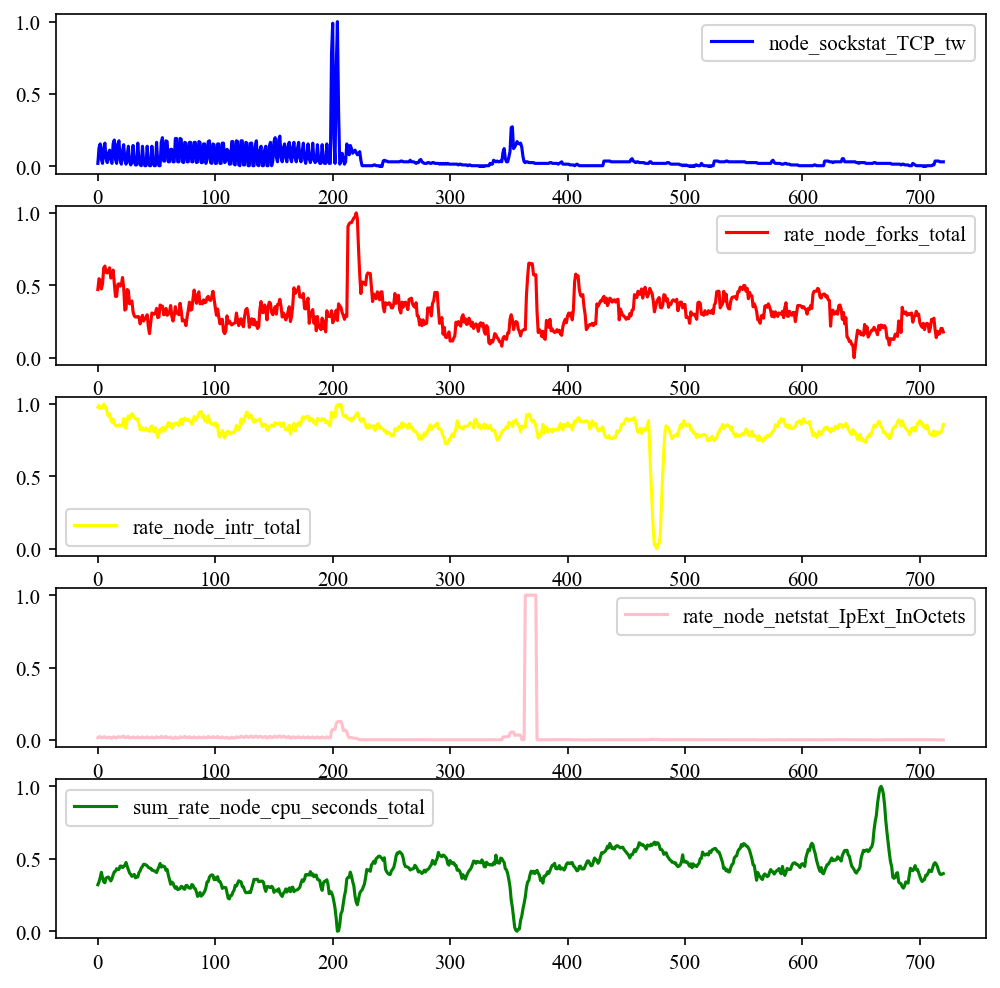

In [134]:
plot_plot(anomaly)

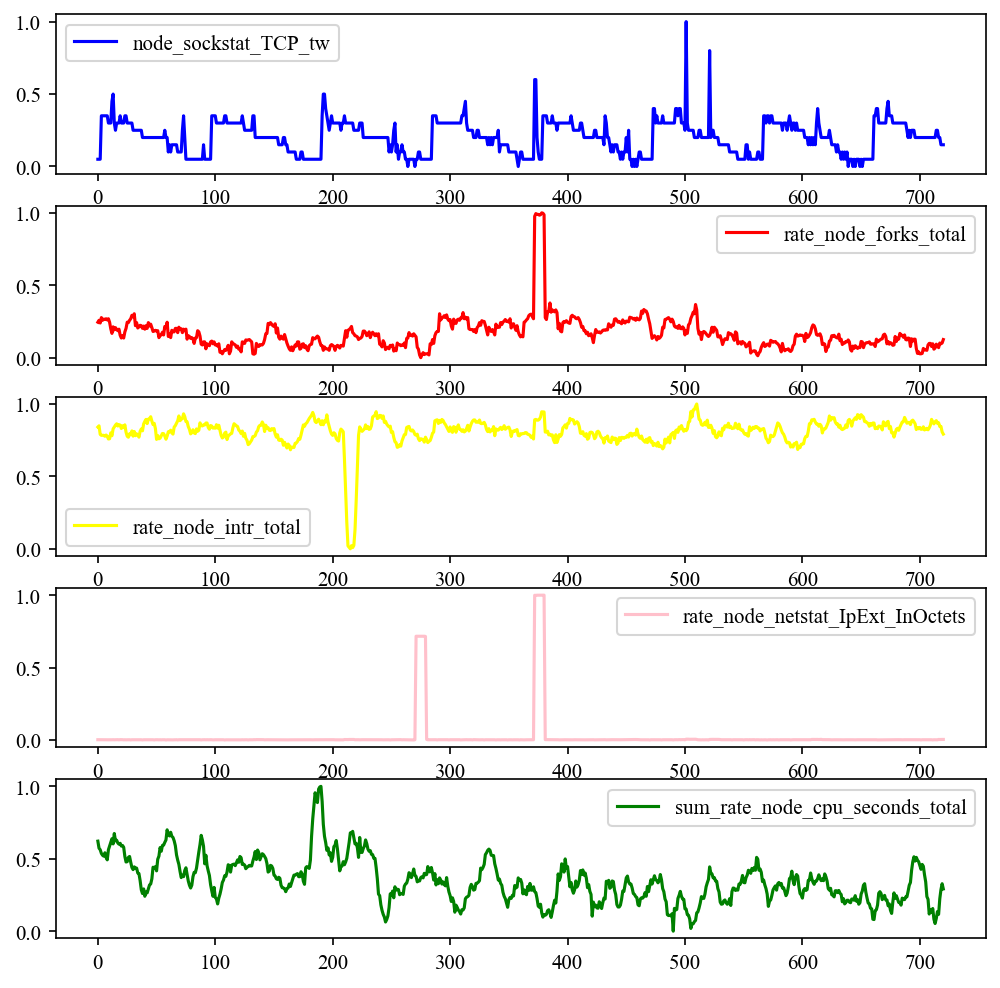

In [135]:
plot_plot(normal)